# BST 267: Introduction to Social and Biological Networks (2021)

# Final Project

A dangerous pathogen is circulating among the U.S. population. Fortunately, scientists have recently been able to develop a vaccine that is 90% effective, i.e., 90% of people who are vaccinated gain full immunity against the pathogen. Regardless of its ability to prevent the disease in 9 out of 10 people, a small number of ill-informed individuals have managed to convince the public that the vaccine is not only ineffective, but also potentially harmful. This anti-vaccine meme has now gone viral on social media and, consequently, more and more people are foregoing the vaccine, thus risking infection not just to themselves but also to the broader community.

There are two networks and two processes unfolding simultaneously in this problem. The first process is the spread of the pathogen on a person-to-person contact network `G_obs`; the second process is the diffusion of an anti-vaccine sentiment on an online social network `H_obs`. The structure of these two networks is distinct; although each consists of the same set of nodes, the ties may or may not overlap. A distinguishing feature between these two networks is that while most people have more or less the same number of ties in their contact network `G_obs`, the mean number of online contacts in network `H_obs` tends to be higher and has a fat-tailed distribution, with the consequence that a small number of individuals have disproportionate influence.

For the purposes of this assignment, we generate the graphs `G_obs` and `H_obs` from a model, but you should treat them as observed or empirical graphs, i.e., treat them as if we didn't know what the data generation mechanism is. The fact that you know the models that generated the networks should make it easier for you to interpret the results. For transparency and reproducibility, you should follow best scientific programming practices throughout: include comments in your code, don't copy-paste the code if you need to perform some operation multiple times but instead use functions, and make sure to label each plot carefully.

In [186]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Generate the contact graph.
G_obs = nx.erdos_renyi_graph(5000, 0.0006, seed=2021)

# Generate the online graph.
H_obs = nx.barabasi_albert_graph(5000, 15, seed=2021)


### Question 1: Extracting overlapping largest connected components

Extract the largest connected component (LCC) of each network. Identify the set of nodes that are common to both, i.e., the set of nodes present in the largest connected component of each network. Then form the induced subgraph `G` from the LCC of `G_obs` based on this set of common nodes and another induced subgraph `H` from the LCC of `H_obs` based on the common set of nodes. All subsequent questions will use `G` and `H` constructed here unless otherwise stated. How many nodes and edges does each network have?

In [188]:
# Extract LCCs
LCC_G = max(nx.connected_components(G_obs), key=len)
LCC_H = max(nx.connected_components(H_obs), key=len)
overlapping_nodes = LCC_G.intersection(LCC_H)

# Create Induced subgraphs
G = G_obs.subgraph(overlapping_nodes)
H = H_obs.subgraph(overlapping_nodes)

# Count edges and nodes
print("G has", len(G.nodes()), "nodes and", len(G.edges()), "edges.")
print("H has", len(H.nodes()), "nodes and", len(H.edges()), "edges.")

G has 4690 nodes and 7515 edges.
H has 4690 nodes and 65036 edges.


### Question 2: Degree distributions

Plot the degree distribution of `G_obs` and `G` in one panel and `H_obs` and `H` in another panel. Use a plotting approach that makes it easy to interpret the shape of each distribution.


<IPython.core.display.Javascript object>


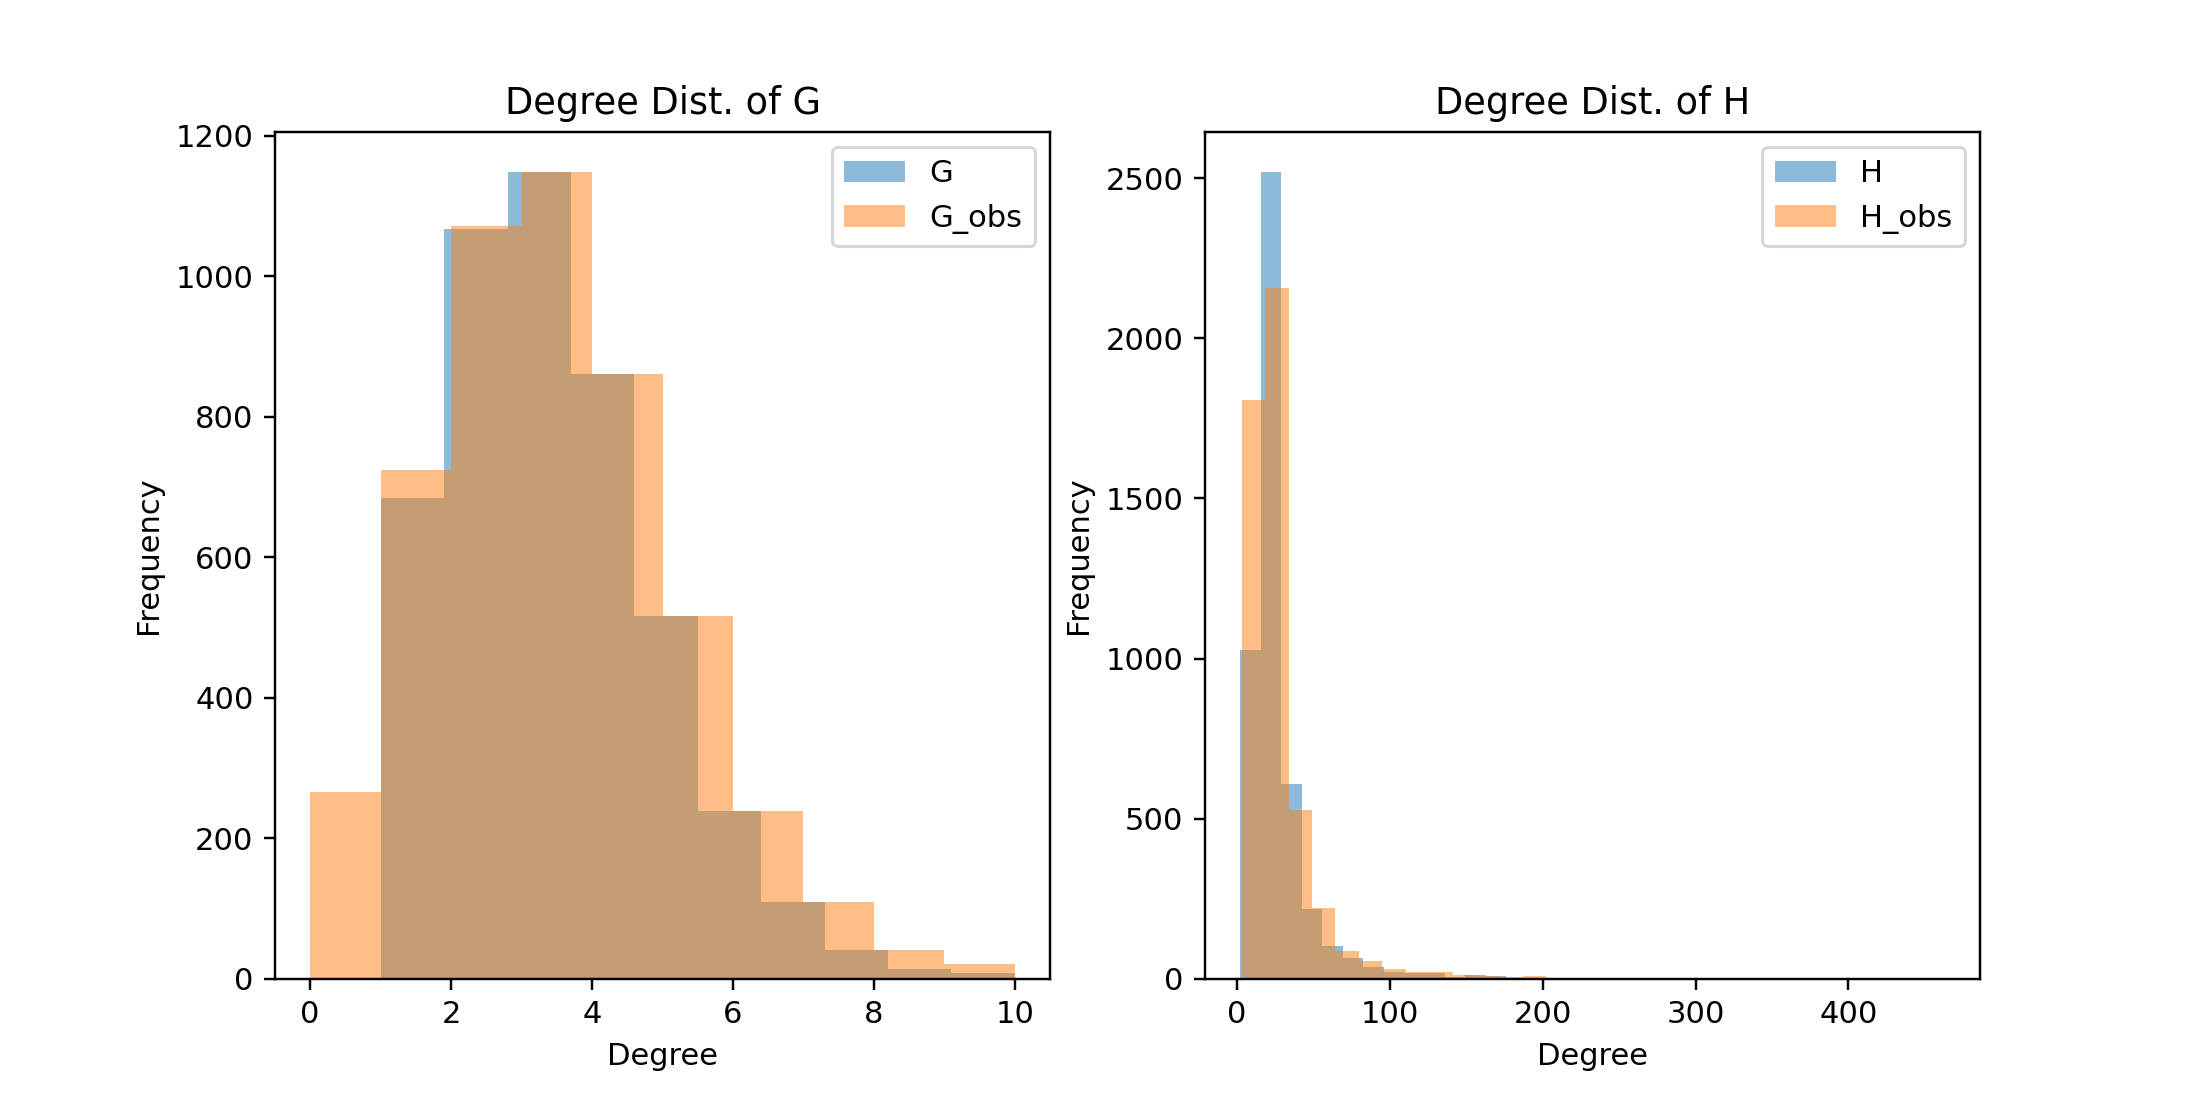

In [340]:
degrees_G = list(dict(G.degree()).values())
degrees_G_obs = list(dict(G_obs.degree()).values())

degrees_H = list(dict(H.degree()).values())
degrees_H_obs = list(dict(H_obs.degree()).values())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(degrees_G, bins = 10, alpha = 0.5)
axs[0].hist(degrees_G_obs, bins = 10, alpha = 0.5)
axs[0].set_title("Degree Dist. of G")
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Degree")
axs[0].legend(["G", "G_obs"])

axs[1].hist(degrees_H, bins = 30, alpha = 0.5)
axs[1].hist(degrees_H_obs, bins = 30, alpha = 0.5)
axs[1].set_title("Degree Dist. of H")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Degree")
axs[1].legend(["H", "H_obs"])

plt.show()

### Question 3: Simulating SIR process

Simulate SIR spreading process on networks `G` and `H`. Set the S to I transition probability to 0.2 and the I to R transition probability to 0.1. Initially only one individual, selected uniformly at random among the nodes, is infected; the rest of the population is susceptible. Use degree infectivity in the SIR simulation, i.e., each infected individual will attempt to infect all their (susceptible) neighbors during each time step. Repeat the simulation 10 times and plot the number of individuals in each of the three states against time in separate panels for the two networks. Explain your findings.

<IPython.core.display.Javascript object>


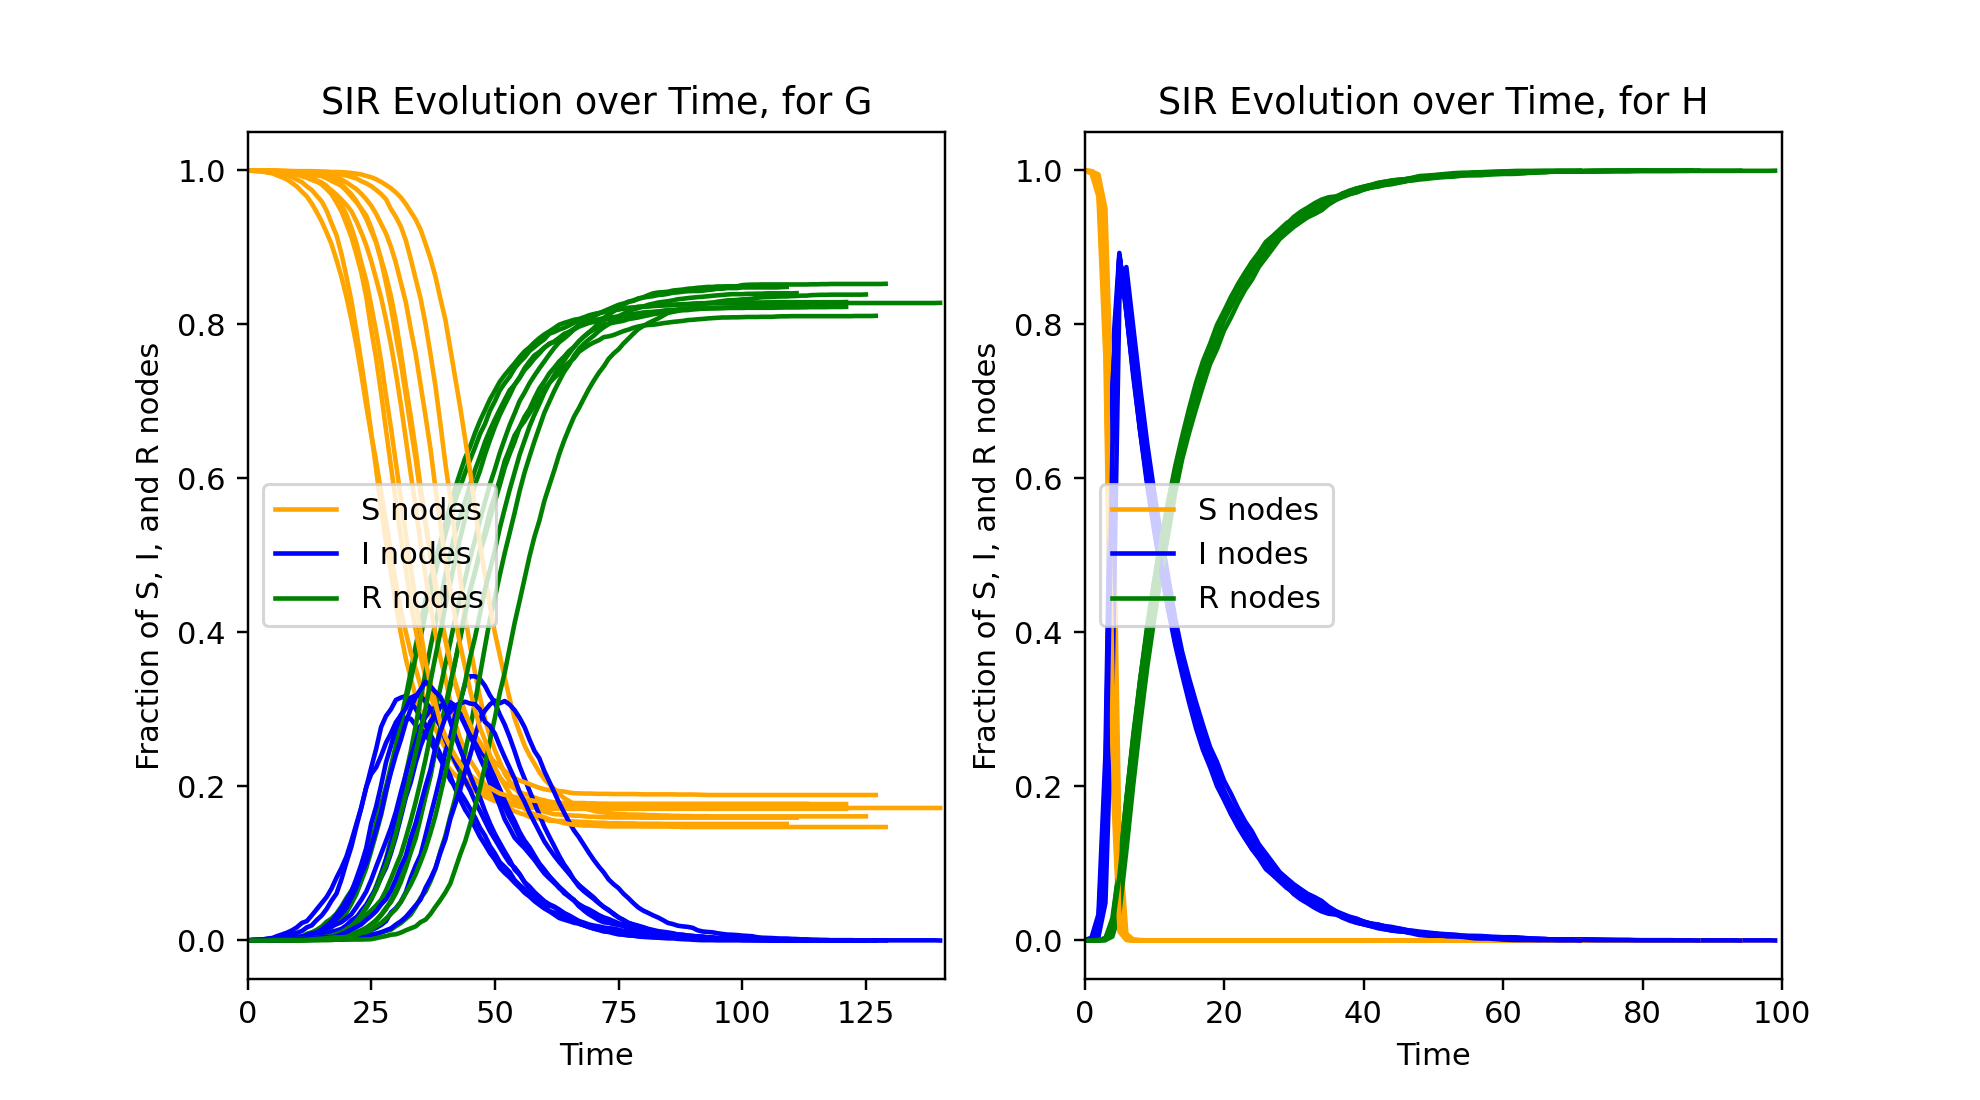

In [325]:
# Carry out the I -> R recovery process for one time step.
def recover(i_nodes, r_nodes , p):
    new_recoveries = []
    for node in i_nodes:
        if random.random() < p:
            new_recoveries.append(node)
    
    for node in new_recoveries:
        r_nodes.append(node)
        i_nodes.remove(node)
    
    return new_recoveries

# Carry out the S -> I spreading process for one time step.
def spread(graph, s_nodes, i_nodes, p):
    new_infections = set()
    
    for i_node in i_nodes:
        if graph.degree(i_node) > 0:
            neighbors = list(graph.neighbors(i_node))
            for neighbor in neighbors:
                if (random.random() < p) and (neighbor in s_nodes):
                    new_infections.add(neighbor)
    
    for node in new_infections:
        i_nodes.append(node)
        s_nodes.remove(node)
    
    return new_infections

# Simulate an epidemic
def simulate(graph, p_si, p_ir, num_seeds):
    i_nodes = random.sample(graph.nodes, num_seeds)
    s_nodes = list(set(graph.nodes()).difference(set(i_nodes)))
    r_nodes = []
    
    num_s_nodes = [len(s_nodes)]
    num_i_nodes = [len(i_nodes)]
    num_r_nodes = [len(r_nodes)]
    
    while len(i_nodes) > 0:
        new_recoveries = recover(i_nodes, r_nodes, p_ir)
        new_infections = spread(graph, s_nodes, i_nodes, p_si)
        
        num_s_nodes.append(len(s_nodes))
        num_i_nodes.append(len(i_nodes))
        num_r_nodes.append(len(r_nodes))
                            
    return (num_s_nodes, num_i_nodes, num_r_nodes)

# Plot
def plot_SIR_process(ax, num_nodes, num_s_nodes, num_i_nodes, num_r_nodes, xlim, num_sims, title):
    plt = ax
    for i in range(num_sims):
        h1, = plt.plot(np.array(num_s_nodes[i]) / num_nodes, color="orange")
        h2, = plt.plot(np.array(num_i_nodes[i]) / num_nodes, color="blue")
        h3, = plt.plot(np.array(num_r_nodes[i]) / num_nodes, color="green")
    plt.set_xlabel("Time")
    plt.set_ylabel("Fraction of S, I, and R nodes")
    plt.set_title(title)
    plt.legend ([h1,h2 ,h3], ["S nodes","I nodes","R nodes"], loc="center left")
    plt.set_xlim([0, xlim ])

# This runs the simulation num_sims times and returns results
def get_SIR_arrays(graph, num_sims, p_si, p_ir, num_seeds):
    num_s_nodes_array = []
    num_i_nodes_array = []
    num_r_nodes_array = []

    for i in range(num_sims):
        (num_s_nodes, num_i_nodes, num_r_nodes) = simulate(graph, p_si, p_ir, num_seeds)
        num_s_nodes_array.append(num_s_nodes)
        num_i_nodes_array.append(num_i_nodes)
        num_r_nodes_array.append(num_r_nodes)
    
    return (num_s_nodes_array, num_i_nodes_array, num_r_nodes_array)

# This is just for getting the max xlim across all simulations for use in plotting
def get_xlim(array_of_arrays):
    max_length = 0
    for array in array_of_arrays:
        if len(array) > max_length:
            max_length = len(array)
    return max_length


p_si = 0.2 
p_ir = 0.1 
num_seeds = 1
num_sims = 10

# Generate SIR data across all simulations for plotting
num_s_nodes_G, num_i_nodes_G, num_r_nodes_G = get_SIR_arrays(G, num_sims, p_si, p_ir, num_seeds)
num_s_nodes_H, num_i_nodes_H, num_r_nodes_H = get_SIR_arrays(H, num_sims, p_si, p_ir, num_seeds)

# xlims for plotting
xlim_G = get_xlim(num_i_nodes_G)
xlim_H = get_xlim(num_i_nodes_H)

# Titles
title_G = "SIR Evolution over Time, for G"
title_H = "SIR Evolution over Time, for H"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plot_SIR_process(ax1, len(G.nodes()), num_s_nodes_G, num_i_nodes_G, num_r_nodes_G, xlim_G, num_sims, title_G)
plot_SIR_process(ax2, len(H.nodes()), num_s_nodes_H, num_i_nodes_H, num_r_nodes_H, xlim_H, num_sims, title_H)

*We see a somewhat extreme result here. In the H network (even with only a single seed), it appears that every node in the graph is infected witin 10 or so days in each of the 10 simulations. On the other hand, in the G network, not every node gets infected, and infections tend to start falling after 30-50 days. About 80% of the population is infected on average in the G graph.*

### Question 4: Reproduction number

Reproduction number for any infectious disease can be succinctly summarized as **the number of persons infected per person infecting**. There are many variants of this concept. The first thing to note is that this number varies during the epidemic. The **basic reproduction number $R_0$** is usually defined as the expected number of cases generated by one case in a fully susceptible population. Because the population is fully susceptible only at the very beginning of an epidemic, $R_0$ may be less informative about what happens later, especially for a network model (vs. mass-action model). The **effective reproduction number $R_t$** is usually defined as the expected number of cases generated by one case at time $t$ in a partially susceptible population. If we set time $t=0$, then $R_t$ coincides with $R_0$.

Calculate the effective reproduction number $R_t$ for the SIR process specified in Question 3 propagating on the contact network `G` in the absence of the vaccine and on the online network `H` in the absence of any preventive measures. Note that these two spreading processes are independent in this question. Repeat the computation 10 times. Make a plot of $R_t$ versus time for each realization. Plot the results for `G` in the left panel and those for `H` in the right panel of the figure. Explain your findings.

<IPython.core.display.Javascript object>


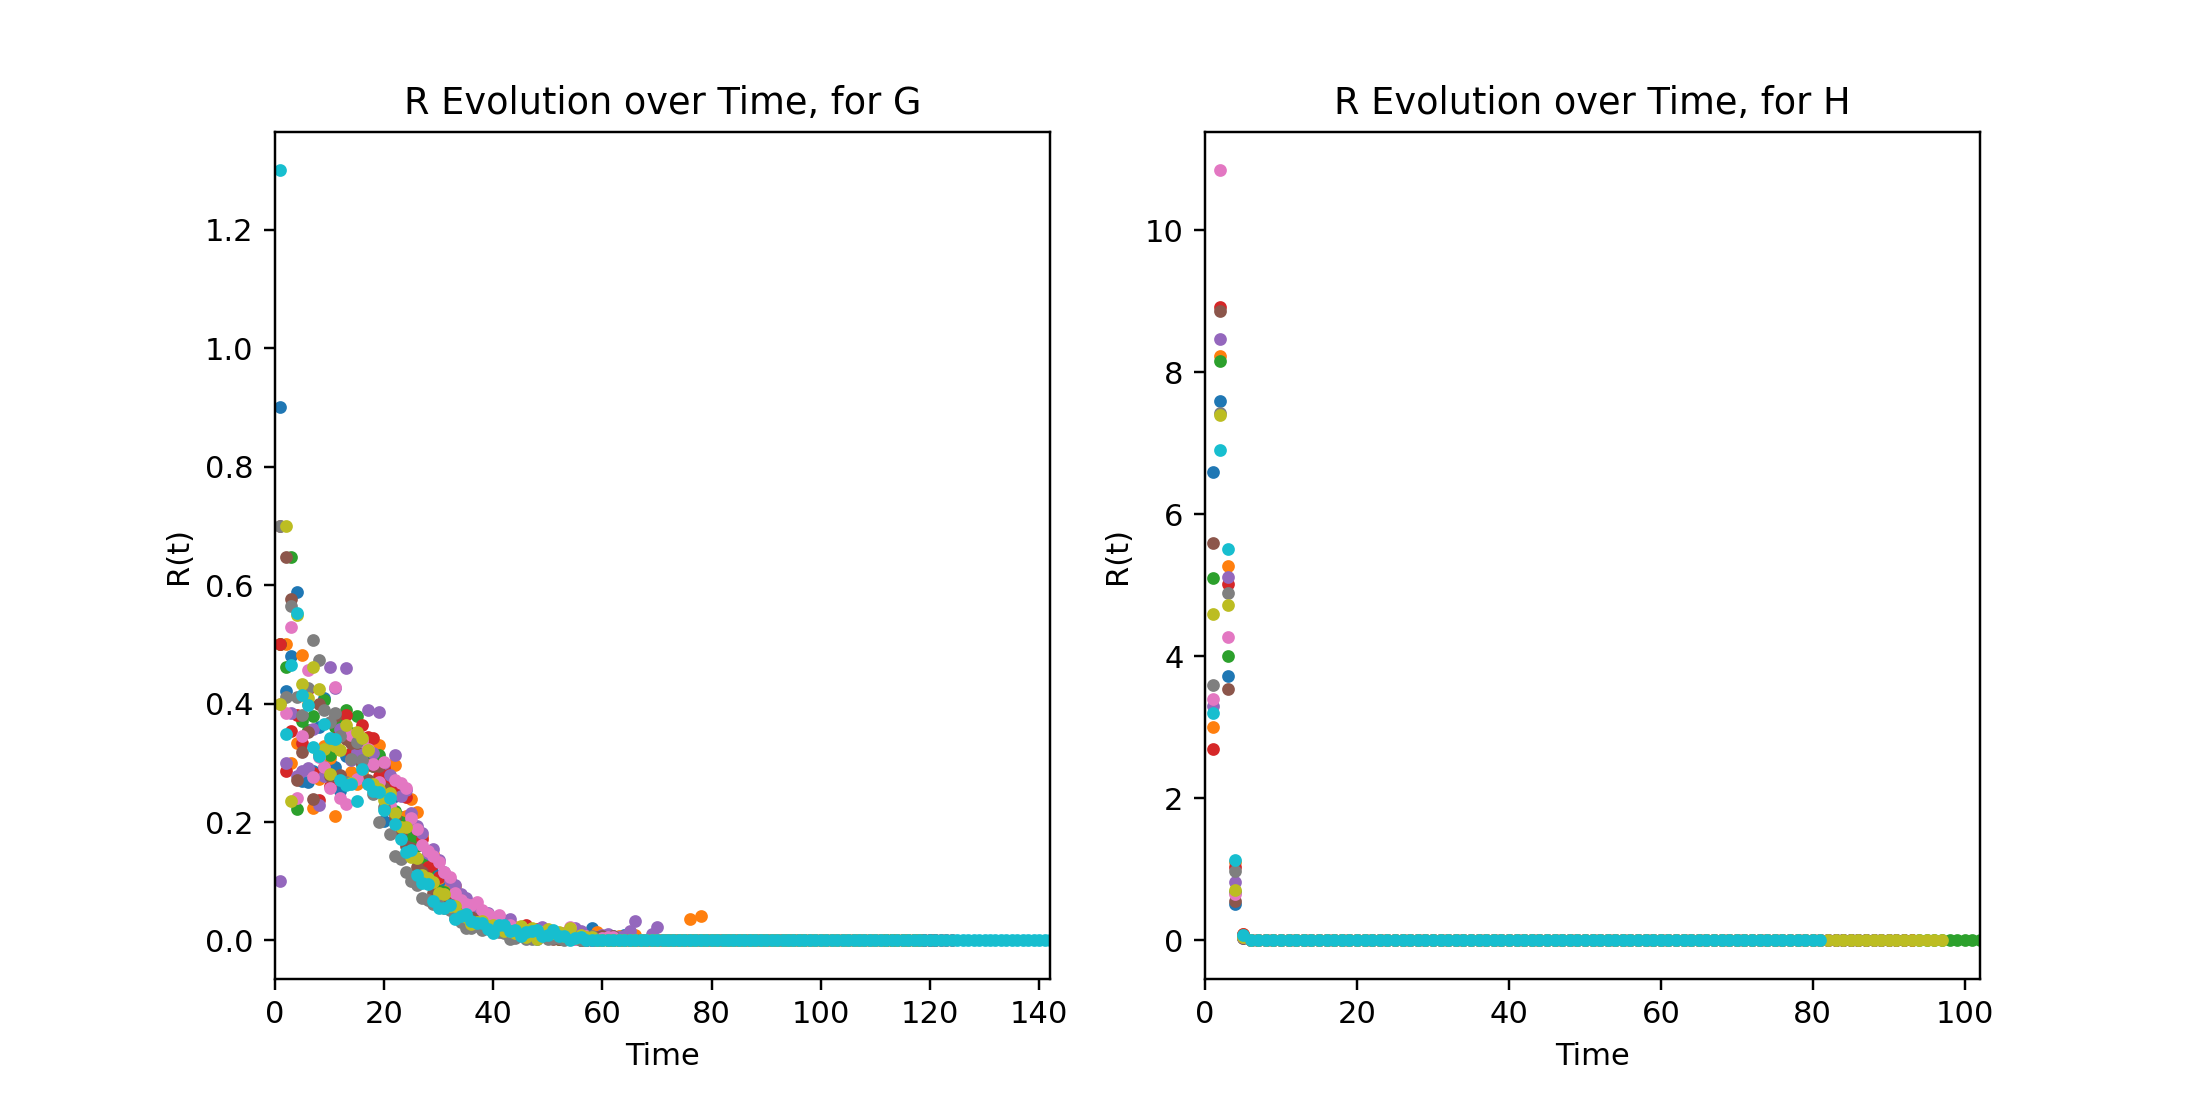

In [343]:
# For plotting results
def plot_R_evolution(ax, new_infections_array, xlim, title, num_sims):
    plt = ax
    for i in range(num_sims):
        time_steps = range(1, len(new_infections_array[i]) + 1)
        new_infections = new_infections_array[i]
        plt.scatter(x = time_steps, y = new_infections, s = 10)
    plt.set_xlabel("Time")
    plt.set_ylabel("R(t)")
    plt.set_title(title)
    plt.set_xlim([0, xlim])

# This simulates the epidemic and returns our metric of interest in each case    
def get_new_infections_per_infected(graph, p_si, p_ir, num_seeds):
    i_nodes = random.sample(graph.nodes, num_seeds)
    s_nodes = list(set(graph.nodes()).difference(set(i_nodes)))
    r_nodes = []
    
    num_i_nodes = [len(i_nodes)]
    num_new_infections = []
    
    while len(i_nodes) > 0:
        new_recoveries = recover(i_nodes, r_nodes, p_ir)
        new_infections = spread(graph, s_nodes, i_nodes, p_si)
    
        num_i_nodes.append(len(i_nodes))
        num_new_infections.append(len(new_infections))
            
    # I index from [0:-1] on num_i_nodes because I want to ignore the case where i_nodes is empty
    return np.array(num_new_infections) / np.array(num_i_nodes[0:-1])

# This runs the simulation num_sims times and returns output for plotting
def get_new_infections_per_infected_arrays(graph, num_sims, p_si, p_ir, num_seeds):
    new_infections_array = []

    for i in range(num_sims):
        new_infections = get_new_infections_per_infected(graph, p_si, p_ir, num_seeds)
        new_infections_array.append(new_infections)

    return new_infections_array

p_si = 0.2
p_ir = 0.1
num_seeds = 1
num_sims = 10

# Generate data across 10 simulations
new_infections_array_G = get_new_infections_per_infected_arrays(G, num_sims, p_si, p_ir, num_sims)
new_infections_array_H = get_new_infections_per_infected_arrays(H, num_sims, p_si, p_ir, num_sims)

# x limits, for plotting
xlim_G = get_xlim(new_infections_array_G)
xlim_H = get_xlim(new_infections_array_H)

# Titles
title_G = "R Evolution over Time, for G"
title_H = "R Evolution over Time, for H"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_R_evolution(ax1, new_infections_array_G, xlim_G, title_G, num_sims)
plot_R_evolution(ax2, new_infections_array_H, xlim_H, title_H, num_sims)

*Our findings here appear consistent with the SIR plots above. In the G network, there is a pretty wide distribution of R_0 across the 10 simulations (this is likely because R_0 is very sensitive to selection of seed node). But in each simulation, R concerges to aroudn 0.35 around day 15, and then slowly decreases to 0 as the susceptible populations decreases.*

*In the H network on the other hand, we see extremely high R values for the first few days, in one case as high as ~11. Then, after every single node is infected in the first 10 or so days, the susceptible population rapidly decreases, and then so does R as the system reaches an equilibrium at this point and there aren't more susceptible ndoes to infect*

### Question 5: Introducing vaccines

Vaccines are here! There is currently enough vaccine supply to vaccinate 1000 people immediately. The probability that the vaccine will confer full immunity in a person is 0.9; otherwise, it will have no effect. The people to be vaccinated are a simple random sample of 1000 individuals from the underlying population, here taken as the set of nodes in `G`. Note that this question deals with the contact network graph `G` only.

Your goal is to assess to what extent the vaccine reduces eventual cumulative incidence, i.e., the total number of cases by the end of the epidemic. Because the choice of the initially infected node is an important source of variability in the spreading process, to assess the effect of the vaccine, for each simulation run you should start the spreading process from the same individual for the two scenarios, no vaccine vs. vaccine. 

In general, the **direct effect** of a vaccine refers to the number of people who took the vaccine and were consequently spared from the infection because of the vaccine; in our case this is the number of people successfully vaccinated. The **total effect** of a vaccine refers to its overall impact in the population, in our case the difference between running the simulation without vaccine vs. running the simulation with the vaccine. Finally, the **indirect effect** refers to the difference between total effect and direct effect, i.e., these are the people who were spared from the infection not because they themselves were vaccinated but because some of the people around them were vaccinated, thus providing a level of herd immunity. 

Simulate each of the two scenarios (no vaccine vs. vaccine) 100 times. You can choose the initially infected node uniformly at random for each repetition of the simulation but keep it fixed within each repetition. Compute and report (1) the average number of people who were successfully vaccinated and thereby immunized (direct effect); (2) the average number of people who were not vaccinated but did not get sick because others were immunized (indirect effect); and (3) the average overall reduction in eventual cumulative incidence (total effect). Explain your findings. If you make any simplifying assumptions, make sure to discuss them.

In this simulation, you can treat the vaccine scenario and the no-vaccine scenario independently. This means that our approach is somewhat naive but still informative. Because of random variability, you may sometimes obtain a negative indirect effect for a simulation run; this only happens because we are treating the two scenarios independently. To calculate the indirect effect in a more robust way would require a more sophisticated approach, which is beyond our scope. However, the indirect effect averaged over all simulation runs should be positive here as well.

In [337]:
# Simulate the epidemic in this vaccine setting
def simulate_with_vax(graph, p_si, p_ir, seed_node, vaccine):
    if vaccine == True:
        # I decided to sample from a Bin(1000, 0.9) distribution to determine how many nodes were successfully
        # vaccinated in each simulation. The expectated value of this distribution is 900. 
        number_successfully_vaxed = np.random.binomial(1000, 0.9)
        successfully_vaccinated_nodes = set(random.sample(graph.nodes, number_successfully_vaxed))
    else:
        successfully_vaccinated_nodes = set()
        
    # Initalize SIR process. NOTE that I remove successfully vaccinated nodes from s_nodes.
    i_nodes = [seed_node]
    s_nodes = list(set(graph.nodes()).difference(set(i_nodes)).difference(successfully_vaccinated_nodes))
    r_nodes = []
        
    num_new_infections = []
    while len(i_nodes) > 0:
        new_recoveries = recover(i_nodes, r_nodes, p_ir)
        new_infections = spread(graph, s_nodes, i_nodes, p_si)
        num_new_infections.append(len(new_infections))
                               
    return (sum(num_new_infections), len(successfully_vaccinated_nodes))

# Repeat the simulations num_sims times and return results
def repeat_simulation_with_vax(num_sims, graph, p_si, p_ir):
    # Initialize arrays which will hold results of each simulation
    num_infected_vaccines = []
    num_infected_no_vaccines = []
    direct_effects = []
    total_effects = []
    indirect_effects = []
    for i in range(num_sims):
        # Select seed node
        seed_node = random.choice(list(graph.nodes()))
        
        # Run simulations
        num_infected_vaccine, num_protected_vaccine = simulate_with_vax(graph, p_si, p_ir, seed_node, True)
        num_infected_no_vaccine, num_protected_no_vaccine = simulate_with_vax(graph, p_si, p_ir, seed_node, False)
        
        # Populate arrays with simulations results 
        num_infected_vaccines.append(num_infected_vaccine)
        num_infected_no_vaccines.append(num_infected_no_vaccine)
        direct_effects.append(num_protected_vaccine)
        total_effects.append(num_infected_no_vaccine - num_infected_vaccine)
        indirect_effects.append((num_infected_no_vaccine - num_infected_vaccine) - num_protected_vaccine)
    
    # Return a 5-tuple with results for printing 
    return (np.mean(num_infected_vaccines), np.mean(num_infected_no_vaccines), np.mean(direct_effects), np.mean(indirect_effects), np.mean(total_effects))

num_sims = 100
p_si = 0.2
p_ir = 0.1

mean_infected_vax, mean_infected_no_vax, mean_direct_effect, mean_indirect_effect, mean_total_effect = repeat_simulation_with_vax(num_sims, G, p_si, p_ir)
print("The mean number of infected nodes with vaccines is", mean_infected_vax)
print("The mean number of infected nodes without vaccines is", mean_infected_no_vax)
print("The mean total effect is", mean_total_effect)            
print("The mean direct effect is", mean_direct_effect)
print("The mean indirect effect is", mean_indirect_effect)

The mean number of infected nodes with vaccines is 1341.96
The mean number of infected nodes without vaccines is 2494.95
The mean total effect is 1152.99
The mean direct effect is 899.63
The mean indirect effect is 253.36


*What we see is there there are many more infections in the case without vaccines than in the case with vaccines. My simulation (even with 100 trials) did not have especially consistent results when repeated many times, but here I see that the mean direct effect is about 900 (this is expected since 900 is the expected value of Bin(1000, 0.9). But in this case the indirect effect, while sizable, is not as large as the direct effect. The vaccines prevented 1153 infection on average - this is a lot, percentage-wise.*

### Question 6: Spread of misinformation

Vaccine resistance is spreading online! According to the rumor, the vaccine doesn't work and may in fact cause severe illness. Based on prior research, it's known that the rumor behaves like an SI process on the online social network `H` with transmission probability `p_rumor=0.05`. To make matters worse, the rumor spread starts from the person in network `H` with the largest following, i.e., the node with the highest degree in the `H` network. 

In this question, we assume that the vaccine is not initially available, and the online rumor gets to spread for the first four weeks (the first 28 days) in the online network `H`. During this time, the pathogen will spread freely in the contact network `G` as there is no vaccine. Vaccines will become available and will be delivered instantaneously at the very beginning of day 29 to a randomly chosen 1000 individuals in the network. People who have bought into the pseudo-science spread by the rumor will refuse to get vaccinated. But because the vaccine can only be stored for a short period of time, it will not be possible to administer the dose to another person. Therefore, if a person is selected for immunization and they've bought into the rumor, the vaccine will be wasted. If a person who is already infected happens to get the vaccine, the vaccine will also be wasted.

Repeat the simulation 20 times and determine the mean number of individuals infected during the epidemic. On average, how many cases (compared to the result of Question 5) can be attributed to the online antivax rumor?

In [338]:
def simulate_with_misinfo(G, H, p_rumor, p_ir, p_si):
    # To keep track of new infections
    num_new_infections = []
    
    # Initialize SIR virus spreading process
    i_nodes_virus = random.sample(G.nodes, 1)
    s_nodes_virus = list(set(G.nodes()).difference(set(i_nodes_virus)))
    r_nodes_virus = []
    
    # Initialize SI rumor spreading process
    node_of_largest_degree = sorted(H.degree, key=lambda x: x[1], reverse=True)[0][0]
    i_nodes_rumor = [node_of_largest_degree]
    s_nodes_rumor = list(set(H.nodes()).difference(set(i_nodes_rumor)))
    
    # Simultate first 28 days
    for i in range(28):
        # Spread rumor
        spread(H, s_nodes_rumor, i_nodes_rumor, p_rumor)
        
        # Spread vius
        new_recoveries = recover(i_nodes_virus, r_nodes_virus, p_ir)
        new_infections = spread(G, s_nodes_virus, i_nodes_virus, p_si)
        num_new_infections.append(len(new_infections))

    # Administer vaccine (I assume it is still only 90% effective)
    number_successfully_vaxed = np.random.binomial(1000, 0.9)
    successfully_vaccinated_nodes = set(random.sample(G.nodes, number_successfully_vaxed))
    
    # We need to remove those who have received the vaccine from s_nodes. We need to handle 2 cases:
        # 1) If they have already been infected, the vaccine will be wasted on them
        # 2) If they believe the rumor, the vaccine will be wasted on them
    # Problem 1) is handled automatically because already-infected nodes aren't in s_nodes_virus. And we handle 
    # Problem 2) by removed those i_nodes_rumor from those conferred infection by successful vaccination. 
    vaxed_and_no_rumor = successfully_vaccinated_nodes.difference(set(i_nodes_rumor))
    new_s_nodes_virus = set(s_nodes_virus).difference(vaxed_and_no_rumor)
    
    # Simultate the remainder of the epidemic
    while len(i_nodes_virus) > 0:
        new_recoveries = recover(i_nodes_virus, r_nodes_virus, p_ir)
        new_infections = spread(G, new_s_nodes_virus, i_nodes_virus, p_si)
        num_new_infections.append(len(new_infections))
        
    return sum(num_new_infections)

# Repeat simulation and return results
def repeat_simultation_with_misinfo(num_sims, G, H, p_rumor, p_ir, p_si):
    num_infections_array = []
    for i in range(num_sims):
        num_infections = simulate_with_misinfo(G, H, p_rumor, p_ir, p_si)
        num_infections_array.append(num_infections)
    
    return np.mean(num_infections_array)

p_rumor = 0.05
num_sims = 20
p_si = 0.2
p_ir = 0.1

average_infections = repeat_simultation_with_misinfo(num_sims, G, H, p_rumor, p_ir, p_si)
print("The average number of infections per simulation of the epidemic is", average_infections)

The average number of infections per simulation of the epidemic is 2537.75


*Here we find that the average number of infections per simulation is 2538. In the setting with vaccines and no misinformation in question 5, there were only 1342 cases on average; therefore 1196 cases are attritibutable to misinformation on average.*  

*This is a lot - and is in fact 2537 is similar to the number of infected without vaccines above (2494). In fact, the reason they are so close is because vaccines are likely have no effect whatsoever, the way the simulation in Q6 was constructed.* 

*We saw earlier how quickly spread occurs on the H network (and that all nodes are infected within 10-15 days or so). Well, in this example we gave the the H network a full 28 days to spread, AND we required that the seed node was the highest degree node.* 

*This means that (even though p_rumor is only 0.05, less than in question 2), in most simulations the entire population has fallen victim to the misinformation by the time the vaccines are administered. This means that all still-susceptible people refuse to take the vaccine when it is available, and it is as if the vaccines do not exist.* 

